# 2D Spot Detection with ImageJ

## Discipline: Spot / object counting (SptCnt)

Task: Estimate the number of objects

This project illustrates the 2D counting of small vesicle like objects.

## The input images

The images were generated by [SIMCEP](http://www.cs.tut.fi/sgn/csb/simcep/tool.html), a widefield fluorescence microscopy biological images simulator.

First set paths to the input and ground-truth folders and create the output folder.

In [1]:
IN_FOLDER = "/home/jovyan/data/in/"
GT_FOLDER = "/home/jovyan/data/gt/"
OUT_FOLDER = "/home/jovyan/data/out/"

!mkdir -p $OUT_FOLDER

The input images are in the [ome-tiff](https://docs.openmicroscopy.org/ome-model/6.0.1/ome-tiff/) format.

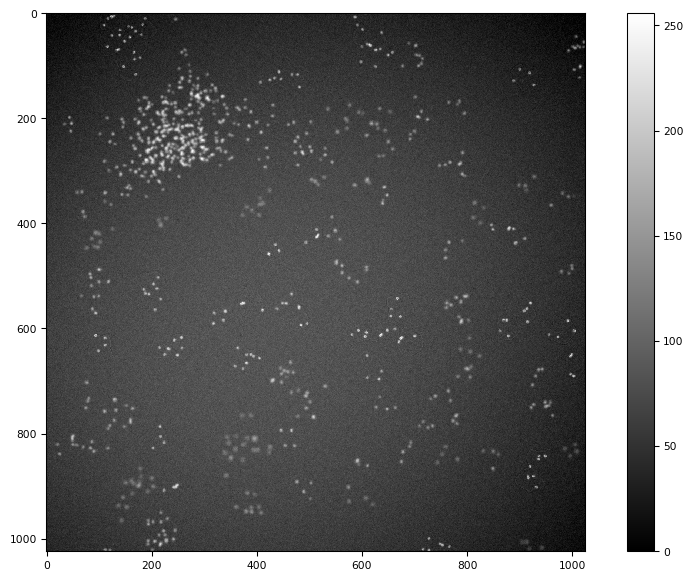

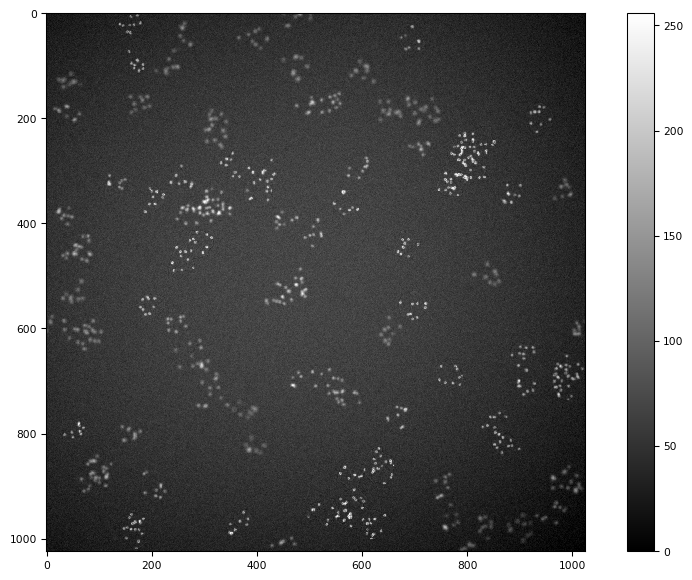

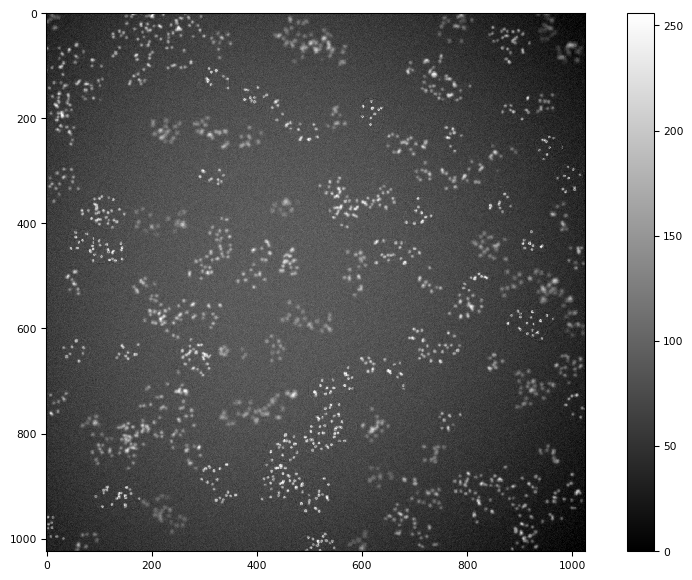

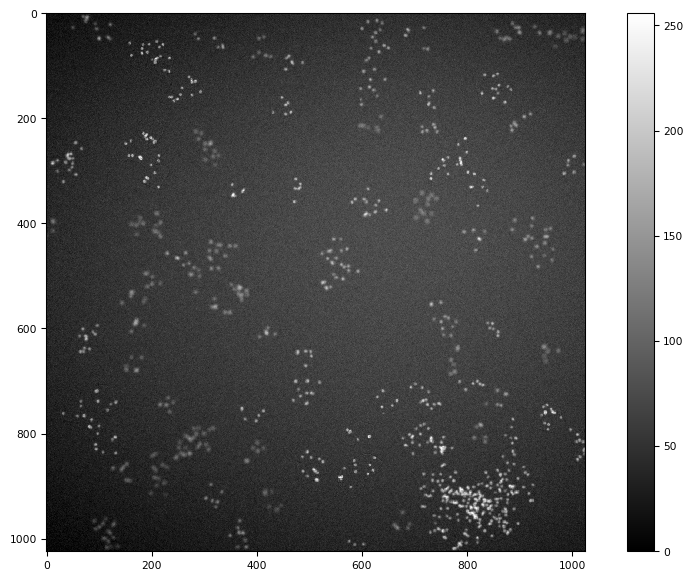

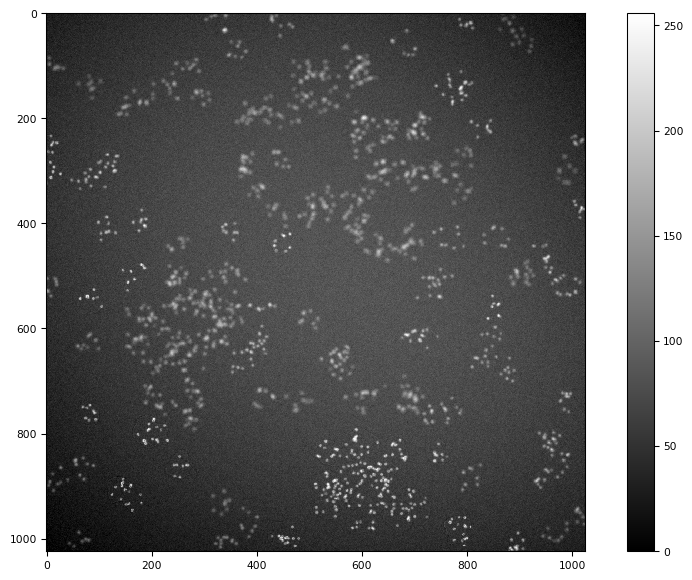

In [10]:
import os
import tifffile
import matplotlib.pyplot
files = [i.path for i in os.scandir(IN_FOLDER) if i.is_file()]
in_paths_sources = [i for i in files if ('.tif' in i) ]
sources = []
for path in in_paths_sources:
    source = tifffile.imread(path)
    tifffile.imshow(source, cmap='gray')
    sources.append(source)
 

## The image analysis workflow

The ImageJ macro uses the Laplacian of Gaussian filter from [FeatureJ](https://imagej.net/FeatureJ) with the given standard deviation of the Gaussian derivative kernels and detects the minima with the given noise tolerance.

In [3]:
from IPython.display import display, Code
code = Code(url='https://raw.githubusercontent.com/Neubias-WG5/W_SpotDetection-IJ/f2d8bd9a2ff74e56d9c80a98f0ab73838caca029/IJSpotDetection.ijm')
display(code)

// Author: Sébastien Tosi (IRB Barcelona)
// Version: 1.0
// Date: 21/04/2017

// The default input and output folder
inputDir = "/dockershare/667/in/";
outputDir = "/dockershare/667/out/";

// Functional parameters
LapRad = 2;
NoiseTol = 2.5;

arg = getArgument();
parts = split(arg, ",");

setBatchMode(true);
for(i=0; i<parts.length; i++) {
	nameAndValue = split(parts[i], "=");
	if (indexOf(nameAndValue[0], "input")>-1) inputDir=nameAndValue[1];
	if (indexOf(nameAndValue[0], "output")>-1) outputDir=nameAndValue[1];
	if (indexOf(nameAndValue[0], "radius")>-1) LapRad=nameAndValue[1];
	if (indexOf(nameAndValue[0], "noise")>-1) NoiseTol=nameAndValue[1];
}

images = getFileList(inputDir);

for(i=0; i<images.length; i++) {
	image = images[i];
	if (endsWith(image, ".tif")) {
		// Open image
		open(inputDir + "/" + image);
		width = getWidth();
		height = getHeight();
		
		// Processing
		run("Clear Results", "");
		run("FeatureJ Laplacian", "compute smoothing="+d2s(LapRad,2));
		run("Find Maxima...", "noise="+d2s(NoiseTol,2)+" output=List light");
		
		// Export results
		newImage("Mask", "16-bit black", width, height, 1);
		for(r=0;r<nResults;r++)
		{
			XPos = getResult("X",r);
			YPos = getResult("Y",r);
			setPixel(XPos,YPos,65535);			
		}
		save(outputDir + "/" + image);
		// Cleanup
		run("Close All");
	}
}
run("Quit");

## Running the workflow

The parameters for running the workflow are:
* --infolder: the folder containing the input images
* --gtfolder: the folder containing the ground truth data, only needed for benchmarking
* --outfolder: the folder into which the result images will be written

It has 3 switches that control the usage of the BIAflows server:
* --nodownload: the images are not downloaded from the server, they must already be in the input folder
* --noexport: the workflow results are only written into the output folder, but not uploaded to the server
* --nometrics: the metrics are neither computed nor uploaded to the server

If the analysis workflow has parameters these must also be passed. Their names can be found at the end of the file [descriptor.json](https://github.com/Neubias-WG5/W_SpotDetection-IJ/blob/master/descriptor.json).

The workflow parameters are:

* STD_DEV: The standard deviation of the Gaussian derivative kernels used for computing the second-order partial derivatives of the Laplacian. Must be larger than zero. The value is realated to the size of the spots that should be detected. The bigger the spots are the bigger the STD_DEV should be. See also the [documentation of FeatureJ](https://imagescience.org/meijering/software/featurej/laplacian/).

* NOISE: The noise tolerance for detecting the minima in the filtered image. Minima are ignored if they do not stand out from the surroundings by more than this value. See also the [ImageJ user guide](https://imagej.nih.gov/ij/docs/guide/146-29.html).

In [4]:
STD_DEV = 2
NOISE = 2.5

In [5]:
!python /app/wrapper.py  --ij_radius $STD_DEV --ij_noise $NOISE --infolder $IN_FOLDER --gtfolder $GT_FOLDER --outfolder $OUT_FOLDER --nodownload --noexport --nometrics

Progress: 0  % ... Status: 2 - 'Running workflow for problem class 'SptCnt' in 2D'
Progress: 0  % ... Status:   - 'Initialisation...'
Progress: 25 % ... Status:   - 'Launching workflow...'
Progress: 90 % ... Status:   - 'Computing and uploading metrics...'
Progress: 100% ... Status: 3 - 'Finished.'


## Displaying the results

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.measure import label, regionprops
from skimage.color import label2rgb


files = [i.path for i in os.scandir(OUT_FOLDER) if i.is_file()]
paths_sources = [i for i in files if ('.tif' in i) ]
pointImages = []
index = 0
nrOfSpots = []

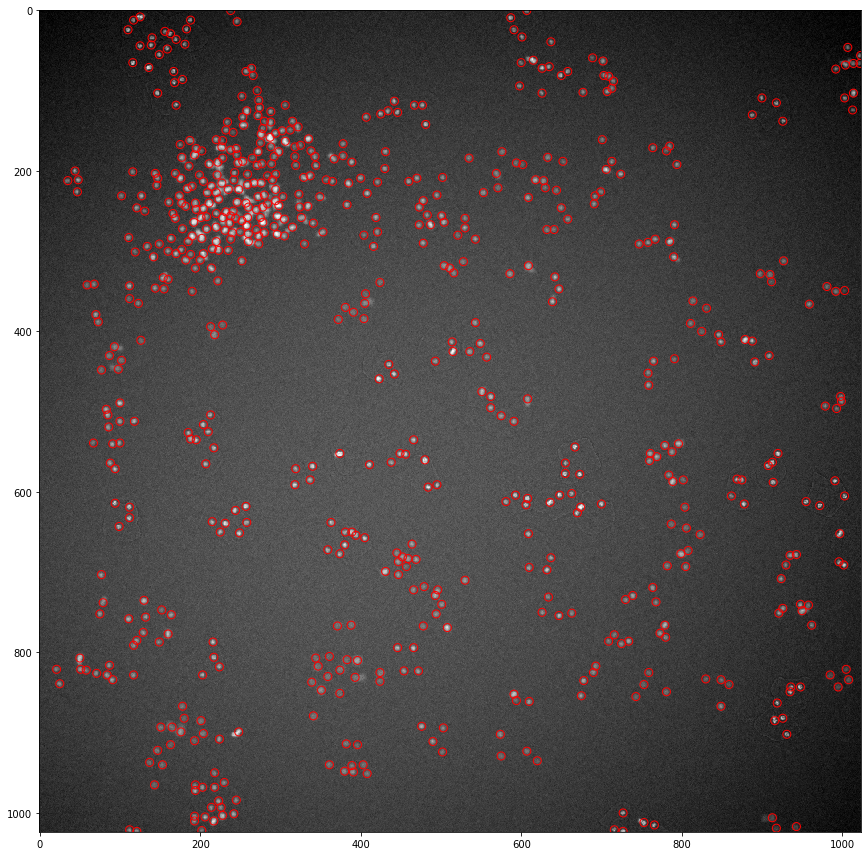

number of spots: 674


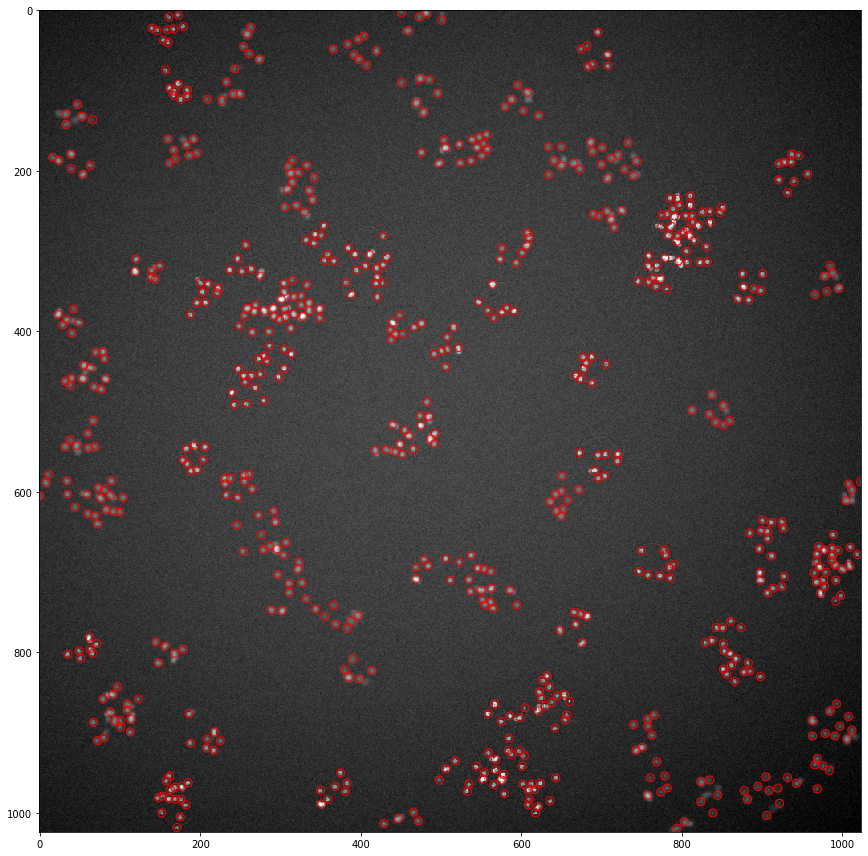

number of spots: 709


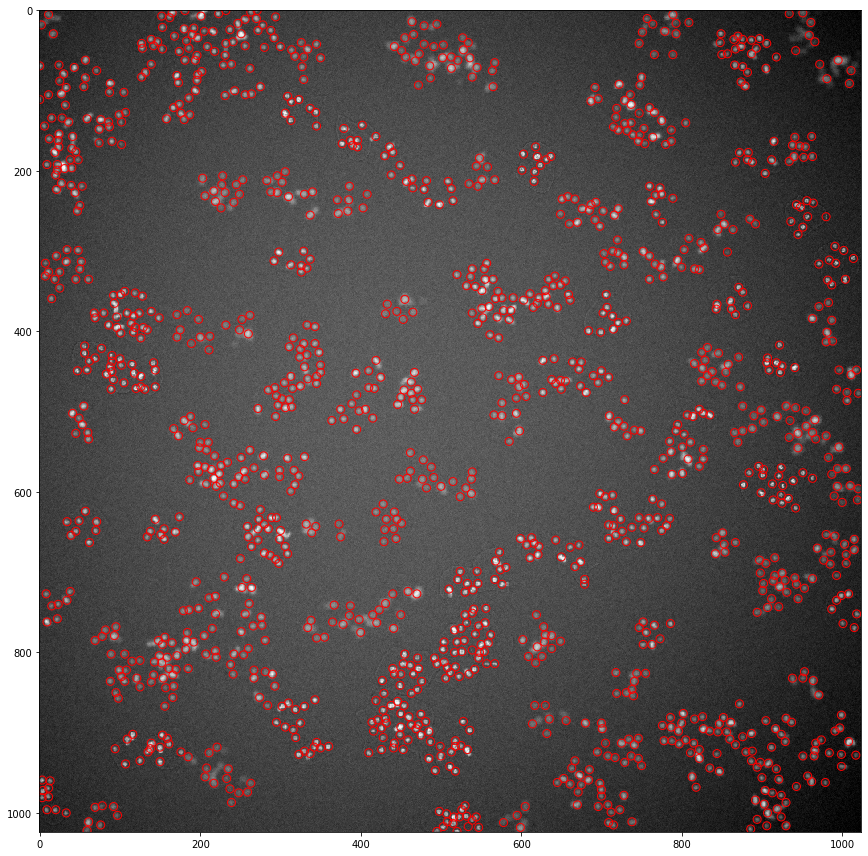

number of spots: 1402


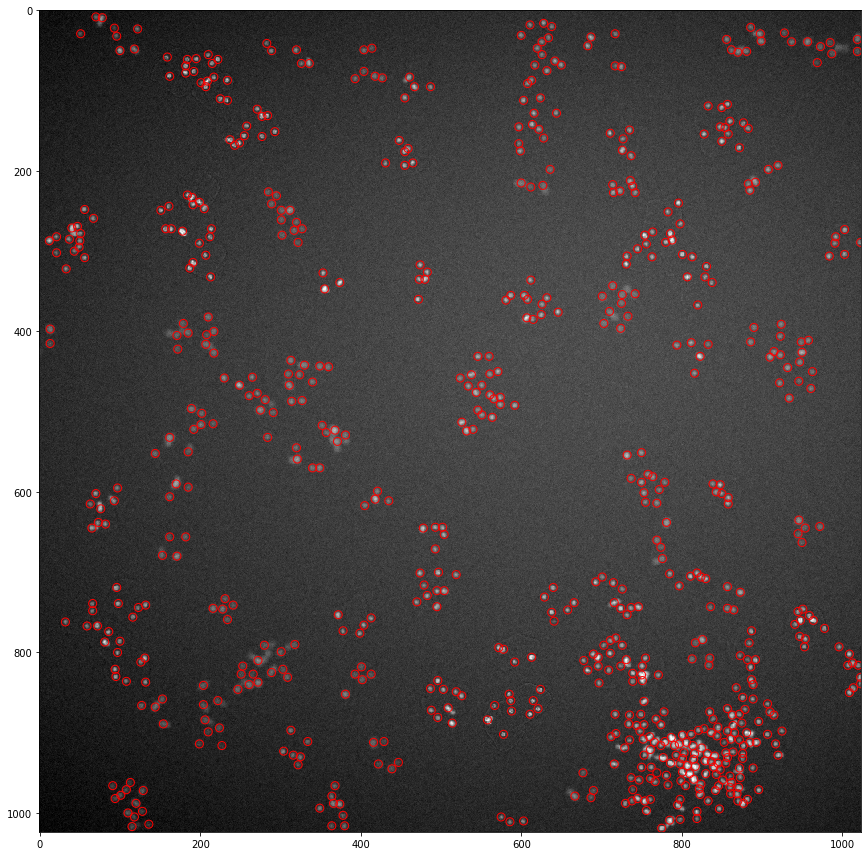

number of spots: 715


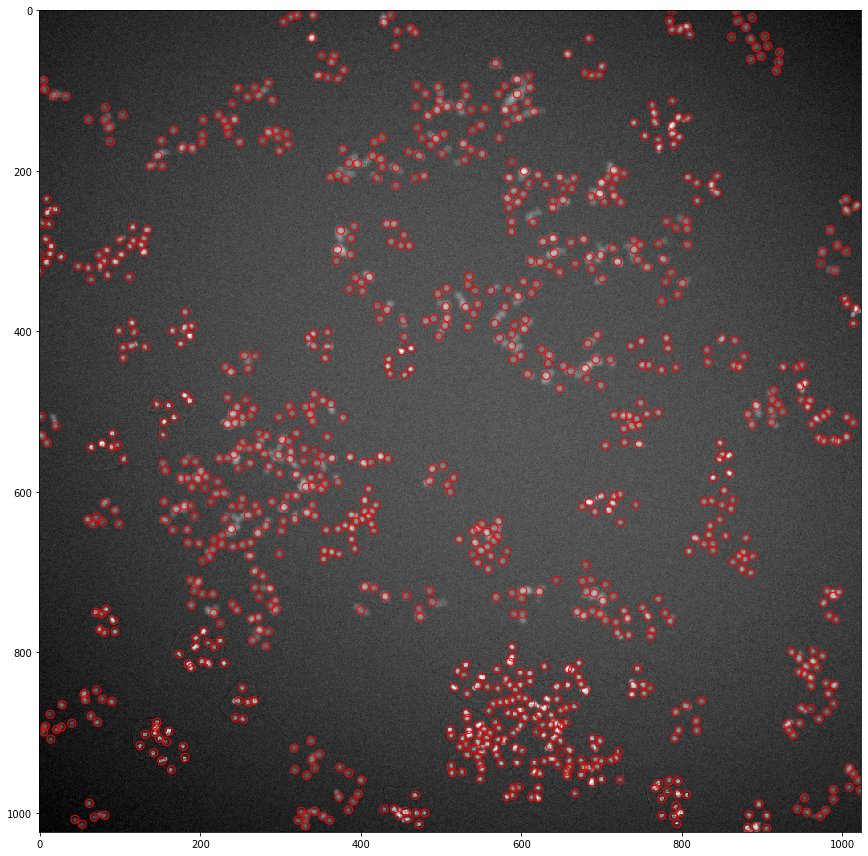

number of spots: 1011


In [7]:
for path in paths_sources:
    fig, ax = plt.subplots(figsize=(20, 12))
    pointImage = tifffile.imread(path)
    label_image = label(pointImage)
    image_label_overlay = label2rgb(label_image, image=sources[index])
    ax.imshow(sources[index], cmap="gray")
    spotCount = 0
    for region in regionprops(label_image):
        (x,y) = region.centroid
        radius = region.equivalent_diameter/2.0
        rect = mpatches.Circle((y,x), 5, fill=False, edgecolor='red')
        ax.add_patch(rect)
        spotCount = spotCount + 1
    nrOfSpots.append(spotCount)
        
    index = index + 1
    plt.tight_layout()
    plt.show()
    print("number of spots: " + str(spotCount))

Finally we display the number of spots for each image:

In [8]:
import statistics
index = 0
for path in in_paths_sources:
    print(path + "\t" + str(nrOfSpots[index]))
    index = index + 1
    
print("Mean" + "\t" + str(statistics.mean(nrOfSpots)))
print("StdDev" + "\t" + str(statistics.stdev(nrOfSpots)))


/home/jovyan/data/in/Img_0003_Spt.tif	674
/home/jovyan/data/in/Img_0004_Spt.tif	709
/home/jovyan/data/in/Img_0001_Spt.tif	1402
/home/jovyan/data/in/Img_0002_Spt.tif	715
/home/jovyan/data/in/Img_0005_Spt.tif	1011
Mean	902.2
StdDev	310.6778073825036


And we calculate and display a boxplot of the distribution of the number of cells per image.

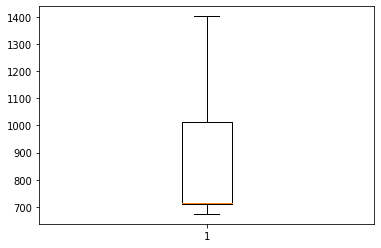

In [9]:
plt.boxplot(nrOfSpots)
plt.show()